In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
line_type = {'solid line' : 'solid', ## 라인 유형
             'dashed line' : 'dashed',
             'dash-dotted line' : 'dashdot',
             'dotted line' : 'dotted'}

In [3]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [4]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


In [5]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [6]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [7]:
train_data.shape,test_data.shape

((210,), (60,))

In [8]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


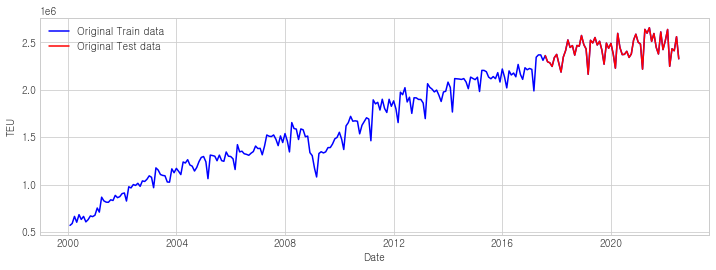

In [9]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Original Train data')
plt.plot(test_data, 'red', label='Original Test data')
plt.legend()

### 2. 다변량 LSTM

In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

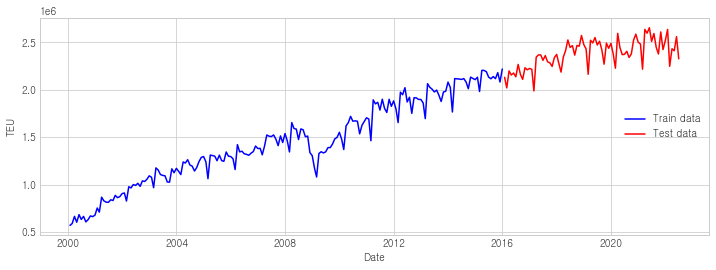

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend(loc=5)

In [17]:
len(train),len(test)

(192, 78)

In [18]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 12   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [22]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_train.shape,Y_train.shape

((163, 18, 10), (163, 12, 1))

### 2. X_test,Y_test 배열

In [24]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_test= X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_test= Y 종속변수 예측값 

In [25]:
X_test.shape,Y_test.shape

((49, 18, 10), (49, 12, 1))

In [26]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [27]:
n_hidden = 64
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(Y_train.shape[1], Y_train.shape[2]))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='tanh',return_state = True, return_sequences=True)(input_train)

encoder_stack_h = MCDropout(0.8)(encoder_stack_h)
encoder_last_h = MCDropout(0.8)(encoder_last_h)
encoder_last_c = MCDropout(0.8)(encoder_last_c)

decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)

decoder_stack_h = LSTM(n_hidden, activation = 'tanh',
                       return_state =False , 
                       return_sequences = True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

decoder_stack_h = MCDropout(0.8)(decoder_stack_h)

attention = dot([decoder_stack_h, encoder_stack_h], axes = [2,2])
attention = Activation('softmax')(attention)

context = dot([attention, encoder_stack_h], axes = [2,1])

decoder_combined_context = concatenate([context, decoder_stack_h])

out = TimeDistributed(Dense(8,activation='relu'))(decoder_combined_context)
out = TimeDistributed(Dense(1))(out)

model = Model(inputs=input_train, outputs = out)
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics = ['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
16/16 [==============================] - 7s 242ms/step - loss: 0.2616 - mae: 0.4352 - val_loss: 0.0832 - val_mae: 0.2374
Epoch 2/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0687 - mae: 0.1980 - val_loss: 0.0884 - val_mae: 0.2715
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0341 - mae: 0.1471 - val_loss: 0.0351 - val_mae: 0.1536
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0258 - mae: 0.1267 - val_loss: 0.0491 - val_mae: 0.1794
Epoch 5/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0241 - mae: 0.1229 - val_loss: 0.0555 - val_mae: 0.2007
Epoch 6/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0206 - mae: 0.1137 - val_loss: 0.0278 - val_mae: 0.1370
Epoch 7/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0180 - mae: 0.1055 - val_loss: 0.0338 - val_mae: 0.1407
Epoch 8/200
16/16 [==============================] - 0s 21ms/step - loss: 0

#### Most Probable Explanation

### 1. 2017.07 ~ 2018.06

In [28]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [29]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [30]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

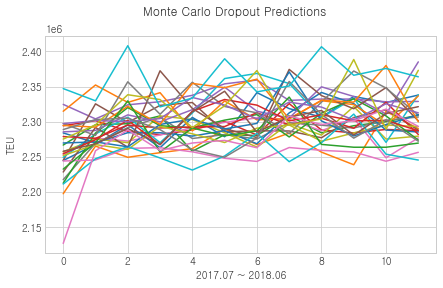

In [31]:
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2018.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [32]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [33]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [34]:
df1 = df
df1.to_csv('df8.csv')

In [42]:
df1 = pd.read_csv('df1.csv')
df2 = pd.read_csv('df2.csv')
df3 = pd.read_csv('df3.csv')
df4 = pd.read_csv('df4.csv')
df5 = pd.read_csv('df5.csv')
df6 = pd.read_csv('df6.csv')
df7 = pd.read_csv('df7.csv')
df8 = pd.read_csv('df8.csv')

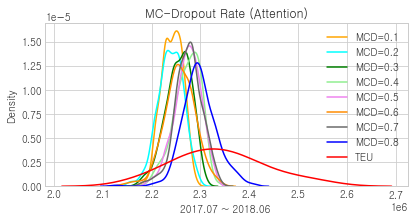

In [45]:
plt.figure(figsize=(6.5,3))
plt.title('MC-Dropout Rate (Attention)')
sns.distplot(df1,color='orange',hist=False,label='MCD=0.1')
sns.distplot(df2,color='cyan',hist=False,label='MCD=0.2')
sns.distplot(df3,color='green',hist=False,label='MCD=0.3')
sns.distplot(df4,color='lightgreen',hist=False,label='MCD=0.4')
sns.distplot(df5,color='violet',hist=False,label='MCD=0.5')
sns.distplot(df6,color='darkorange',hist=False,label='MCD=0.6')
sns.distplot(df7,color='dimgrey',hist=False,label='MCD=0.7')
sns.distplot(df8,color='blue',hist=False,label='MCD=0.8')
sns.distplot(test_data.head(12).reset_index()['TEU'],hist=False,color='red',label='TEU')
plt.xlabel('2017.07 ~ 2018.06 ')
plt.legend()